# 3 - Loan Prediction - Classification

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [2]:
# Function to update all the duplicate rows of a UniqueID with the mode value of its columns 
def updateDuplicates(UniqueID,df,columns):
    # Group the df by UniqueID
    grouped=df.groupby(UniqueID)
    # Loop through each column with different non null values
    for column in columns:
        # initialise dictionary to store the mode_val of each column for each UniqueID
        d={}
        # Loop through each group in grouped 
        for id_val,group_df in grouped:
            # store the mode as pandas series object in mode_val
            mode_val=group_df[column].mode()
            # check if the series is not empty
            if not mode_val.empty:
                # update dictionary with the mode val for current column in its UniqueID
                d[id_val]=mode_val[0]
        # Update all the rows with the corresponding mode val
        df[column]=df[UniqueID].map(d)

In [3]:
# Function to check for columns with different non-null values
def diffColsCheck(UniqueID,df):
    # Group by UniqueID
    grouped = df.groupby(UniqueID)
    columns_with_different_values = []

    for column in df.columns:
        # storing the non values as pandas series in non_null_values
        non_null_values = grouped[column].nunique()
        # checking if any of the values in the series has value greater than(gt) 1 and adding column if True
        if non_null_values.gt(1).any():
            columns_with_different_values.append(column)

    # Return the columns with different non-null values for the same UniqueID
    return columns_with_different_values

In [4]:
# Reading the data
df=pd.read_csv("LoansTrainingSet.csv")

### EDA - Exploratory Data Analysis

In [5]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520,Short Term,741.0,10+ years,Home Mortgage,33694.0,Debt Consolidation,$584.03,12.3,41.0,10,0,6760,16056,0.0,0.0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441,Short Term,734.0,4 years,Home Mortgage,42269.0,other,"$1,106.04",26.3,NaN,17,0,6262,19149,0.0,0.0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029,Short Term,747.0,10+ years,Home Mortgage,90126.0,Debt Consolidation,"$1,321.85",28.8,NaN,5,0,20967,28335,0.0,0.0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743,Short Term,747.0,10+ years,Own Home,38072.0,Debt Consolidation,$751.92,26.2,NaN,9,0,22529,43915,0.0,0.0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,$355.18,11.5,NaN,12,0,17391,37081,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       256984 non-null  object 
 1   Customer ID                   256984 non-null  object 
 2   Loan Status                   256984 non-null  object 
 3   Current Loan Amount           256984 non-null  int64  
 4   Term                          256984 non-null  object 
 5   Credit Score                  195308 non-null  float64
 6   Years in current job          245508 non-null  object 
 7   Home Ownership                256984 non-null  object 
 8   Annual Income                 195308 non-null  float64
 9   Purpose                       256984 non-null  object 
 10  Monthly Debt                  256984 non-null  object 
 11  Years of Credit History       256984 non-null  float64
 12  Months since last delinquent  116601 non-nul

In [7]:
df.isnull().sum()

Loan ID                              0
Customer ID                          0
Loan Status                          0
Current Loan Amount                  0
Term                                 0
Credit Score                     61676
Years in current job             11476
Home Ownership                       0
Annual Income                    61676
Purpose                              0
Monthly Debt                         0
Years of Credit History              0
Months since last delinquent    140383
Number of Open Accounts              0
Number of Credit Problems            0
Current Credit Balance               0
Maximum Open Credit                  0
Bankruptcies                       529
Tax Liens                           23
dtype: int64

In [8]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens
count,2.569840e+05,195308.000000,1.953080e+05,256984.000000,116601.000000,256984.000000,256984.000000,2.569840e+05,256455.000000,256961.000000
mean,1.371331e+07,1251.116099,7.195272e+04,18.290195,34.881450,11.106267,0.156628,1.540656e+04,0.110316,0.027203
std,3.438131e+07,1762.016848,5.887757e+04,7.075747,21.854165,4.982982,0.460731,1.966506e+04,0.336229,0.245950
min,5.050000e+02,585.000000,0.000000e+00,3.400000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8.299000e+03,714.000000,4.432100e+04,13.500000,16.000000,8.000000,0.000000,5.974000e+03,0.000000,0.000000
50%,1.429800e+04,733.000000,6.124200e+04,17.000000,32.000000,10.000000,0.000000,1.107800e+04,0.000000,0.000000
75%,2.436700e+04,744.000000,8.646200e+04,21.700000,51.000000,14.000000,0.000000,1.931900e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,11.000000,1.731412e+06,7.000000,11.000000


In [9]:
df.sample()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
233373,e83ae232-36ac-41a4-8fe1-94c0dc72b125,4d5847e8-97f8-414d-83da-0384c557e482,Fully Paid,11838,Long Term,735.0,4 years,Home Mortgage,36501.0,Debt Consolidation,$723.02,14.8,NaN,15,0,7137,12930,0.0,0.0


#### Unique Loan IDs

In [10]:
df["Loan ID"].nunique()

215700

In [11]:
df.shape

(256984, 19)

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
c

(240374, 19)

### Duplicates Remaining

In [14]:
240374-215700

24674

#### Dealing With Duplicate rows

In [15]:
# Columns with different non null values
columns=diffColsCheck("Loan ID",df)

In [16]:
columns

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Monthly Debt',
 'Current Credit Balance',
 'Maximum Open Credit']

#### Calling Custom Function updateDuplicates

In [17]:
# Calling updateDuplicates function on df to update duplicate rows with mode value in all columns to make it suitable for drop duplicates
updateDuplicates("Loan ID",df,columns)

In [18]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520,Short Term,741.0,10+ years,Home Mortgage,33694.0,Debt Consolidation,$584.03,12.3,41.0,10,0,6760,16056,0.0,0.0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441,Short Term,734.0,4 years,Home Mortgage,42269.0,other,"$1,106.04",26.3,NaN,17,0,6262,19149,0.0,0.0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029,Short Term,747.0,10+ years,Home Mortgage,90126.0,Debt Consolidation,"$1,321.85",28.8,NaN,5,0,20967,28335,0.0,0.0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743,Short Term,747.0,10+ years,Own Home,38072.0,Debt Consolidation,$751.92,26.2,NaN,9,0,22529,43915,0.0,0.0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,$355.18,11.5,NaN,12,0,17391,37081,0.0,0.0


In [19]:
# Now all the duplicate rows in df have same values in all columns  

In [20]:
# Drop Duplicates
df.drop_duplicates(inplace=True)

In [21]:
df.shape

(215700, 19)

#### Duplicates removed

In [22]:
df["Loan ID"].nunique()

215700

## Deal with missing values in columns

In [23]:
df.shape

(215700, 19)

In [24]:
df.isnull().sum()

Loan ID                              0
Customer ID                          0
Loan Status                          0
Current Loan Amount                  0
Term                                 0
Credit Score                     44498
Years in current job              8990
Home Ownership                       0
Annual Income                    44498
Purpose                              0
Monthly Debt                         0
Years of Credit History              0
Months since last delinquent    118262
Number of Open Accounts              0
Number of Credit Problems            0
Current Credit Balance               0
Maximum Open Credit                  0
Bankruptcies                       452
Tax Liens                           22
dtype: int64

#### -Annual Income

In [25]:
df["Annual Income"].isnull().sum()

44498

In [26]:
44498/215700
# more than 20% of the Annual income is misssing. Impute with mean/mode/median

0.20629578117756142

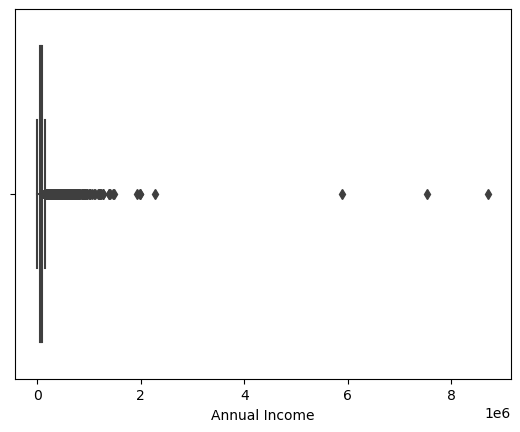

In [27]:
sns.boxplot(x=df["Annual Income"]);

##### Filling missing Annual Income with median ( as outliers distorts the mean value )

In [28]:
df["Annual Income"]=df["Annual Income"].fillna(df["Annual Income"].median())

In [29]:
# Converting to float
df["Annual Income"]=df["Annual Income"].astype(float)

#### -Tax Liens

In [30]:
df["Tax Liens"].unique()

array([ 0.,  5., nan,  1.,  2.,  4.,  3.,  6.,  7.,  9.,  8., 10., 11.])

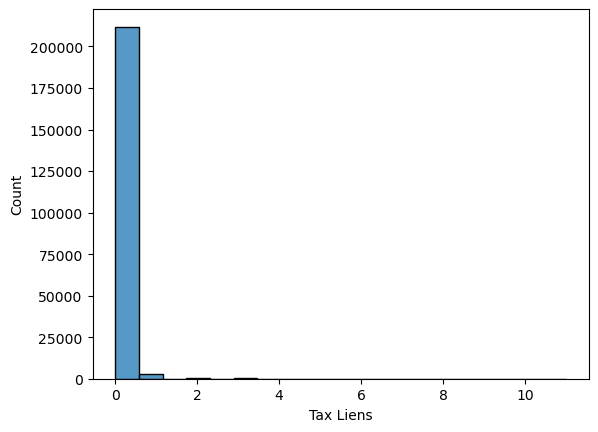

In [31]:
sns.histplot(df["Tax Liens"]);

##### Filling missing Tax Liens with 0

In [32]:
df["Tax Liens"]=df["Tax Liens"].fillna(0)

#### -Bankruptcies

In [33]:
df["Bankruptcies"].unique()

array([ 0.,  1.,  2., nan,  3.,  4.,  5.,  7.,  6.])

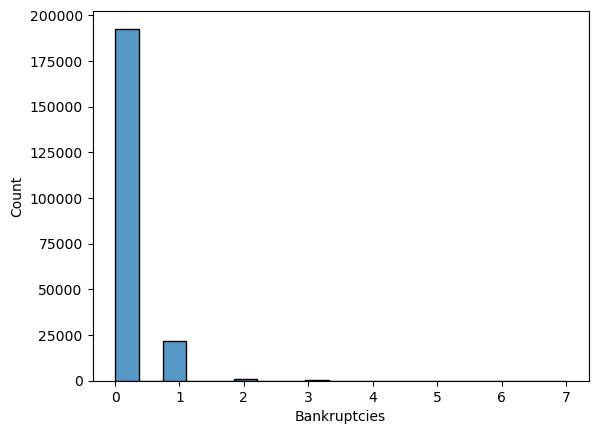

In [34]:
sns.histplot(df["Bankruptcies"]);

##### Filling missing Bankruptcies with 0

In [35]:
df["Bankruptcies"]=df["Bankruptcies"].fillna(0)

#### -Credit Score 

###### Credit Score>800?

In [36]:
df[df["Credit Score"]>800]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
6,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,Charged Off,24613,Long Term,6640.0,6 years,Rent,49225.0,Business Loan,$542.29,17.6,73.0,7,0,14123,16954,0.0,0.0
55,000c0c27-1961-4336-b760-a300e1bce9b0,881edf98-387c-4eef-ab71-317a7a5e70c1,Charged Off,6463,Short Term,7320.0,1 year,Own Home,25248.0,Debt Consolidation,$633.29,19.9,74.0,9,0,8025,24317,0.0,0.0
71,000f1140-ef9f-42f9-9898-f9b3162bf0da,442c2d9b-3d95-44a9-bcb4-0dc80a941e3c,Charged Off,6007,Short Term,7180.0,10+ years,Home Mortgage,43052.0,Debt Consolidation,$538.15,23.6,13.0,6,0,5077,7811,0.0,0.0
161,00291dfe-e40a-4791-acc8-a322ee3d9b72,835f15b4-ccea-46fb-9a1f-1ccda42ae737,Charged Off,6017,Short Term,7130.0,4 years,Rent,44128.0,other,$448.63,8.9,NaN,12,0,7263,19736,0.0,0.0
175,002bd679-cca8-4637-9e21-f07117547ade,ce4134c2-3656-4b45-8a98-7c90ae95ef2e,Charged Off,6840,Short Term,6620.0,< 1 year,Rent,83062.0,Buy House,"$2,208.06",26.4,60.0,20,0,7983,10951,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256803,ffce37ae-4877-4316-b985-ca66e9942861,93330384-1e1d-4f78-8d33-766b40040231,Charged Off,10605,Short Term,7270.0,10+ years,Home Mortgage,70196.0,Debt Consolidation,"$1,164.08",14.5,NaN,16,0,18313,21750,0.0,0.0
256843,ffda0100-49f8-4205-a853-72fd7f709328,ac055546-80ce-4f32-9d32-b2c0ca132d33,Charged Off,24978,Long Term,6890.0,5 years,Home Mortgage,144870.0,Debt Consolidation,"$1,943.67",15.9,34.0,10,2,5563,9287,1.0,0.0
256868,ffe22ad2-1f4c-4ad8-84b4-4c2ed333dcf9,e6bdcc35-8f9c-4691-bbcc-fb35cb489d10,Charged Off,13682,Long Term,6600.0,1 year,Rent,39092.0,Debt Consolidation,$616.68,9.0,NaN,9,0,4464,10455,0.0,0.0
256874,ffe33e62-83b6-4bc2-9ec7-7f865621542e,307dc053-1357-40ac-a394-ad916ecca8ca,Charged Off,1480,Short Term,7350.0,4 years,Rent,34528.0,Debt Consolidation,$417.21,6.5,NaN,13,0,2792,6997,0.0,0.0


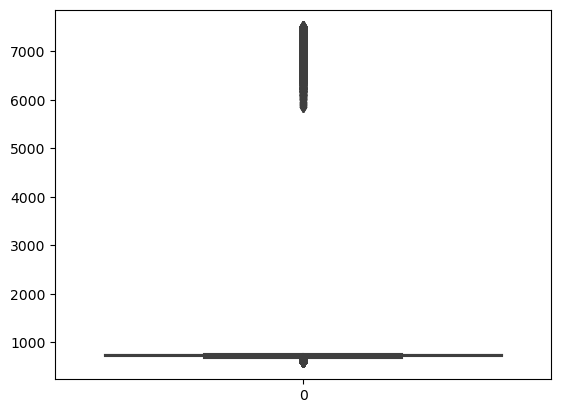

In [37]:
sns.boxplot(df["Credit Score"]);

#### Credit score is higher than 800 in many cases: seems like it must be /10

In [38]:
df.loc[df["Credit Score"] > 800, "Credit Score"] /= 10

<Axes: >

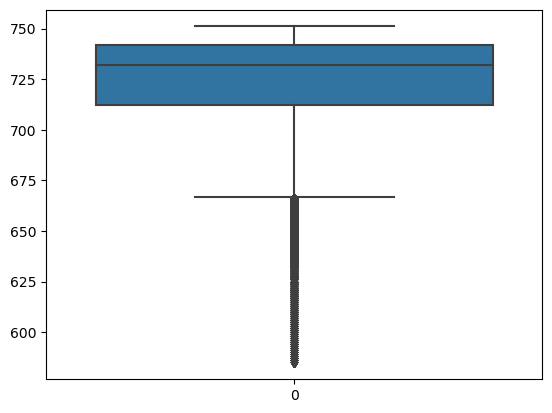

In [39]:
sns.boxplot(df["Credit Score"])

#### Fixed credit score scale difference (Some were in 6000-8000 scale)

##### Filling missing Credit Scores with mean

In [40]:
df["Credit Score"]=df["Credit Score"].fillna(df["Credit Score"].mean())

#### -Maximum Open Credit

##### Converting the #VALUE! to nan type in Max Open Credit

In [41]:
df["Maximum Open Credit"]=df["Maximum Open Credit"].replace("#VALUE!",np.nan)
df["Maximum Open Credit"]=df["Maximum Open Credit"].astype(float)

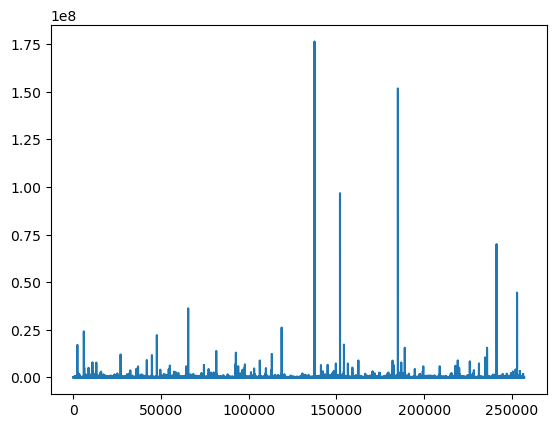

In [42]:
plt.plot(df["Maximum Open Credit"]);

<Axes: >

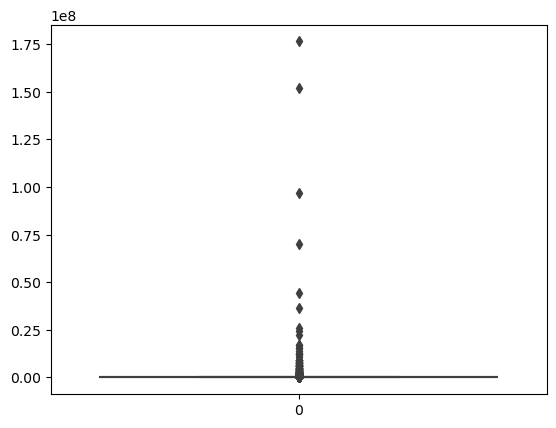

In [43]:
sns.boxplot(df["Maximum Open Credit"])

##### Filling Max Open Credit with median

In [44]:
df["Maximum Open Credit"]=df["Maximum Open Credit"].fillna(df["Maximum Open Credit"].median())

#### -Months since last delinquent

##### Fill null Months since last delinquent with 600(50 yrs)

In [45]:
df["Months since last delinquent"].fillna(600,inplace=True)

#### -Years in current job

In [46]:
df["Years in current job"].unique()

array(['10+ years', '4 years', '6 years', '5 years', nan, '3 years',
       '2 years', '< 1 year', '1 year', '7 years', '9 years', '8 years'],
      dtype=object)

##### nan values must be for no jobs. Fill with N/A

In [47]:
df["Years in current job"]=df["Years in current job"].fillna("N/A")

In [48]:
df.isnull().sum()

Loan ID                         0
Customer ID                     0
Loan Status                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Years in current job            0
Home Ownership                  0
Annual Income                   0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

###   --Missing values resolved--

## Data Visualisation

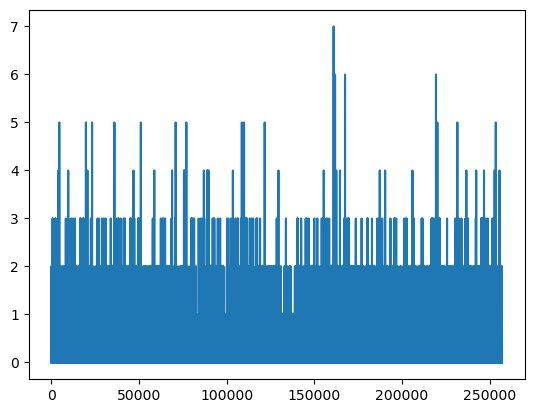

In [49]:
plt.plot(df["Bankruptcies"]);

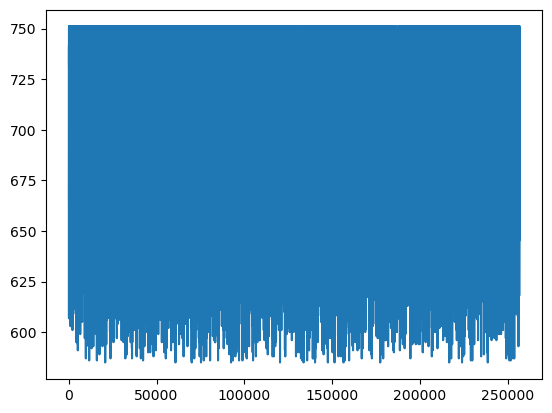

In [50]:
plt.plot(df["Credit Score"]);

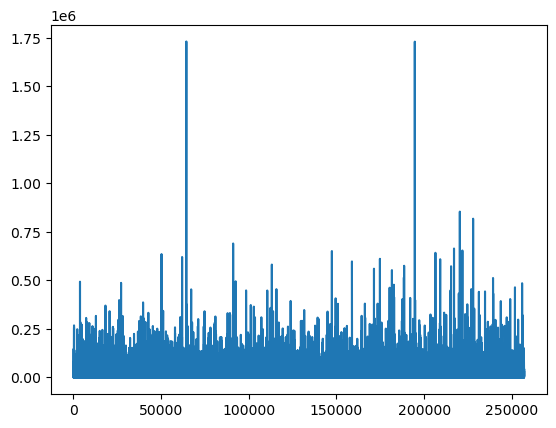

In [51]:
plt.plot(df["Current Credit Balance"]);

#### -Current Loan Amount 99999999?

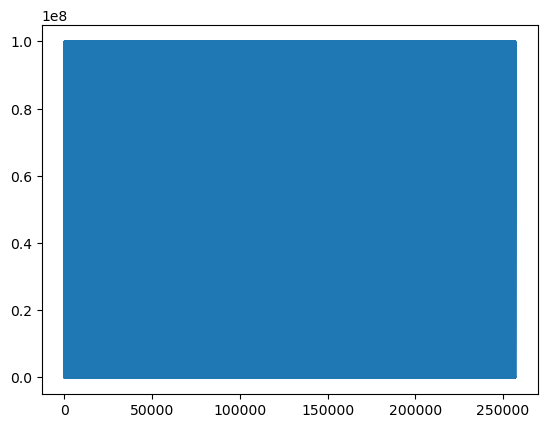

In [52]:
plt.plot(df["Current Loan Amount"]);

In [53]:
df["Current Loan Amount"].mode()

0    99999999
Name: Current Loan Amount, dtype: int64

In [54]:
df[df["Current Loan Amount"]==99999999].shape

(35210, 19)

##### Replacing Curr Loan Amt 99999999 with median

In [55]:
df["Current Loan Amount"]=df["Current Loan Amount"].replace(99999999,df["Current Loan Amount"].median())

<Axes: xlabel='Current Loan Amount', ylabel='Count'>

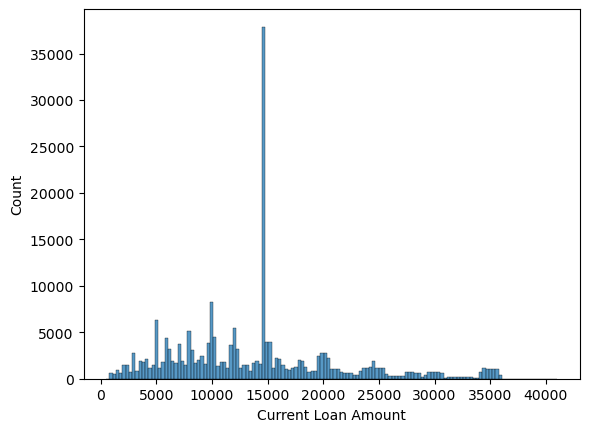

In [56]:
sns.histplot(df["Current Loan Amount"])

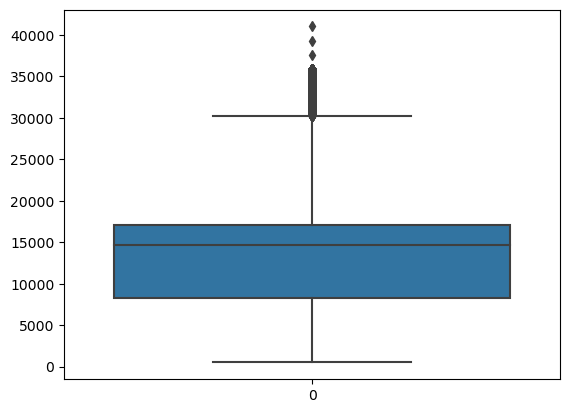

In [57]:
sns.boxplot(df["Current Loan Amount"]);

##### Fixed Current Loan Amount Issue

<Axes: xlabel='Term', ylabel='count'>

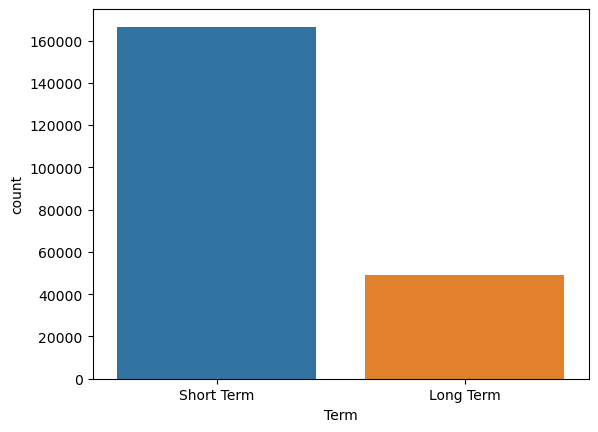

In [58]:
sns.countplot(x=df["Term"])

<Axes: xlabel='Years in current job', ylabel='count'>

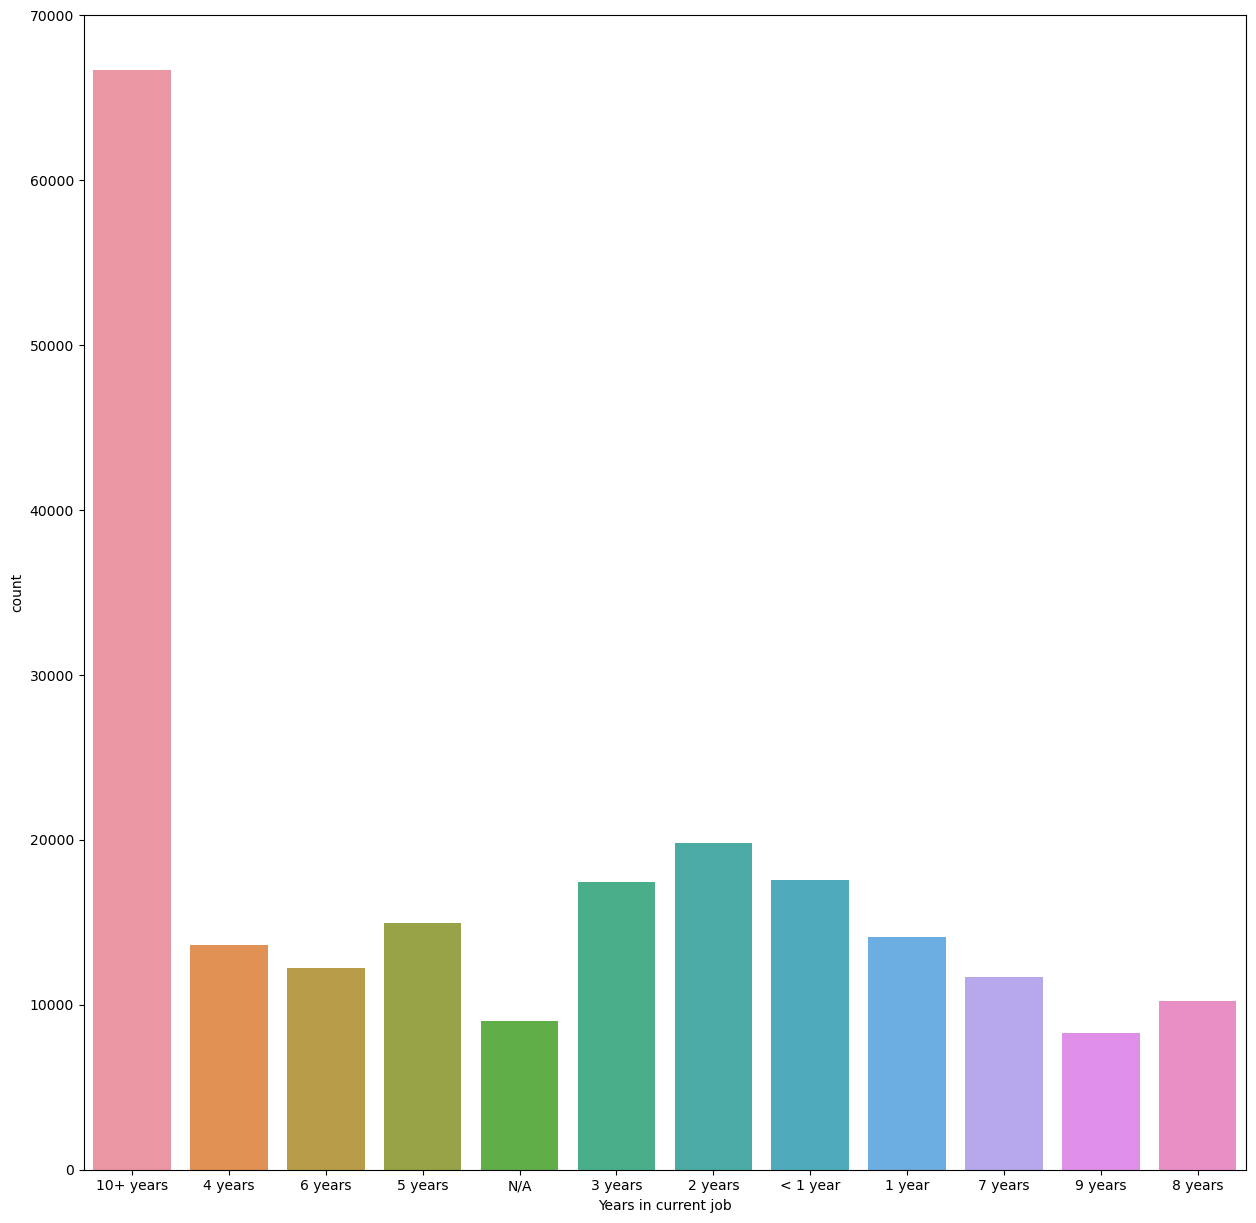

In [59]:
plt.figure(figsize=(15,15))
sns.countplot(x=df["Years in current job"])

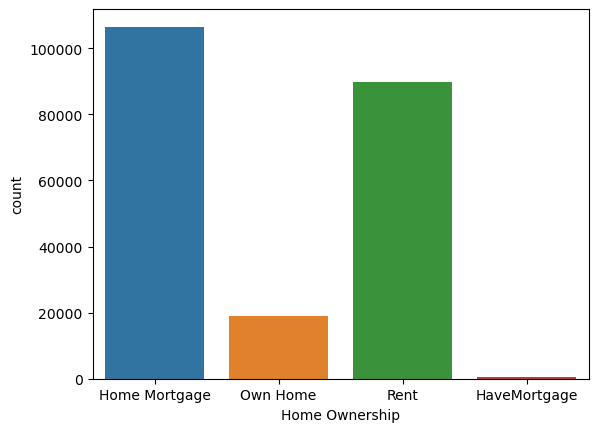

In [60]:
sns.countplot(x=df["Home Ownership"]);

##### Combining Other and other in Purpose

In [61]:
df["Purpose"].unique()

array(['Debt Consolidation', 'other', 'Business Loan',
       'Home Improvements', 'Buy House', 'Other', 'Buy a Car',
       'Medical Bills', 'Take a Trip', 'Educational Expenses'],
      dtype=object)

In [62]:
df["Purpose"]=df["Purpose"].replace("other","Other")

<Axes: xlabel='Purpose', ylabel='count'>

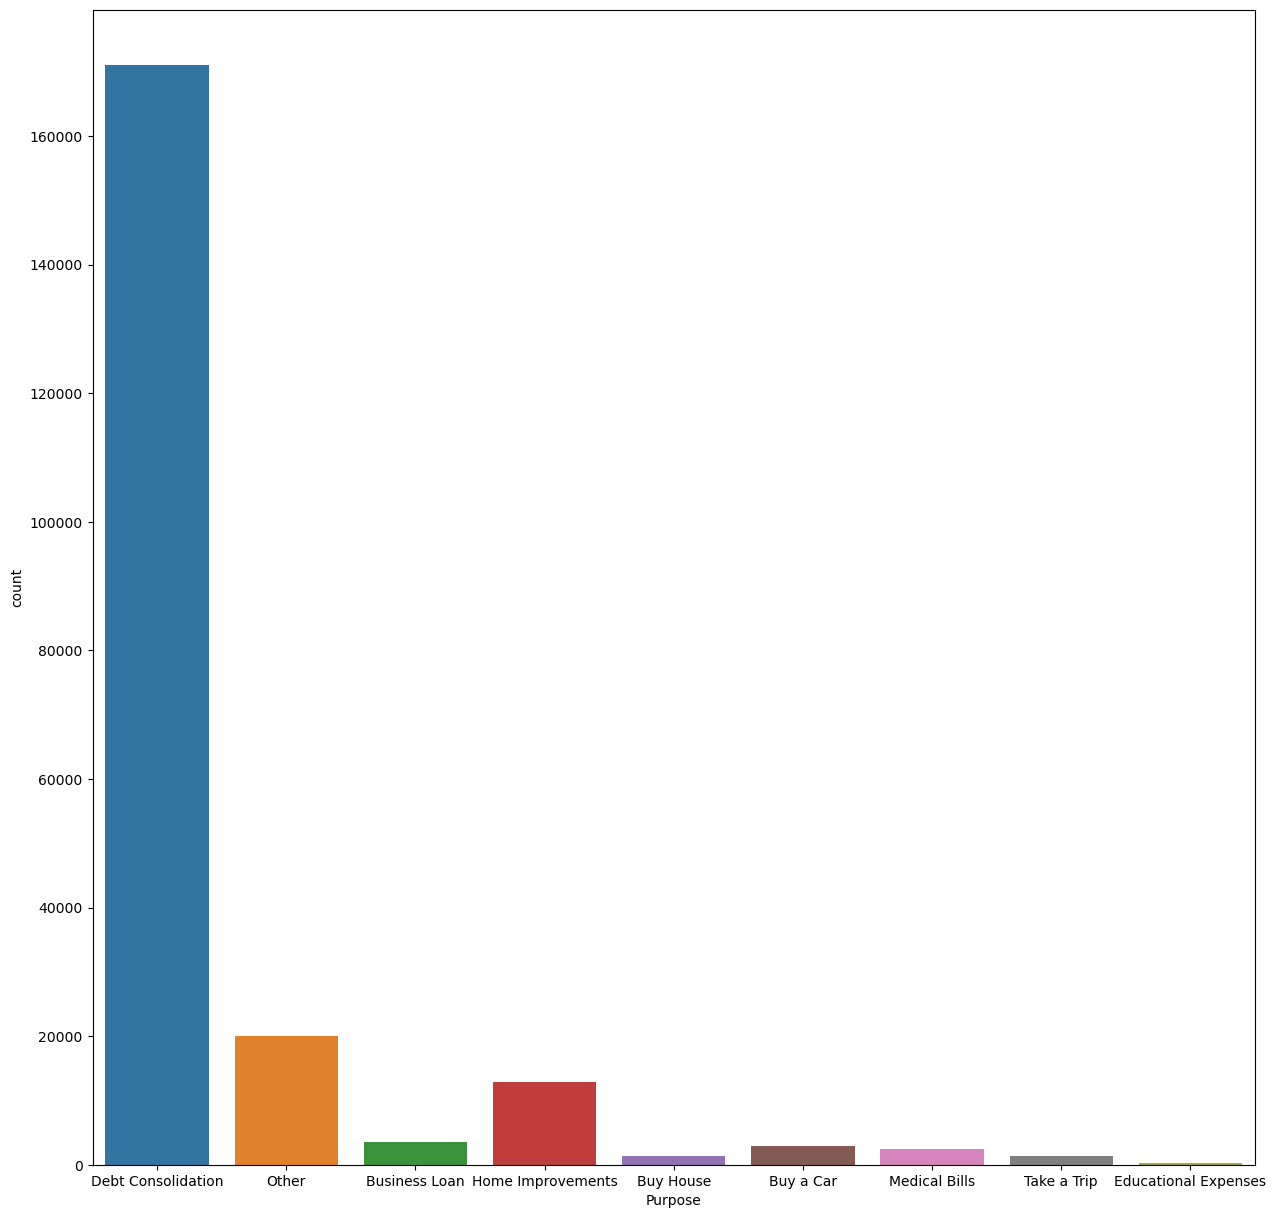

In [63]:
plt.figure(figsize=(15,15))
sns.countplot(x=df["Purpose"])

## Feature Engineering

In [64]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520,Short Term,741.0,10+ years,Home Mortgage,33694.0,Debt Consolidation,$584.03,12.3,41.0,10,0,6760,16056.0,0.0,0.0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441,Short Term,734.0,4 years,Home Mortgage,42269.0,Other,"$1,106.04",26.3,600.0,17,0,6262,19149.0,0.0,0.0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029,Short Term,747.0,10+ years,Home Mortgage,90126.0,Debt Consolidation,"$1,321.85",28.8,600.0,5,0,20967,28335.0,0.0,0.0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743,Short Term,747.0,10+ years,Own Home,38072.0,Debt Consolidation,$751.92,26.2,600.0,9,0,22529,43915.0,0.0,0.0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,$355.18,11.5,600.0,12,0,17391,37081.0,0.0,0.0


##### Converting loan status to 1/0

In [65]:
df["Loan Status"]=df["Loan Status"].replace({"Fully Paid":1, "Charged Off":0})

##### Cleaning the Monthly Debt to convert to float

In [66]:
df["Monthly Debt"]=df["Monthly Debt"].str.replace("$","")
df["Monthly Debt"]=df["Monthly Debt"].str.replace(",","")

In [67]:
df["Monthly Debt"]=df["Monthly Debt"].astype(float)

##### Cleaning Years in current job to numbers

In [68]:
df["Years in current job"].unique()

array(['10+ years', '4 years', '6 years', '5 years', 'N/A', '3 years',
       '2 years', '< 1 year', '1 year', '7 years', '9 years', '8 years'],
      dtype=object)

In [69]:
# map with dictionary
d_year={'10+ years': 15, '4 years': 4, '6 years': 6, 
        '5 years': 5, 'N/A': 0, '3 years': 3, 
        '2 years': 2, '< 1 year': 0.5, '1 year': 1, 
        '7 years': 7, '9 years': 9, '8 years': 8}

In [70]:
df["Years in current job"]=df["Years in current job"].map(d_year)

<Axes: xlabel='Years in current job', ylabel='count'>

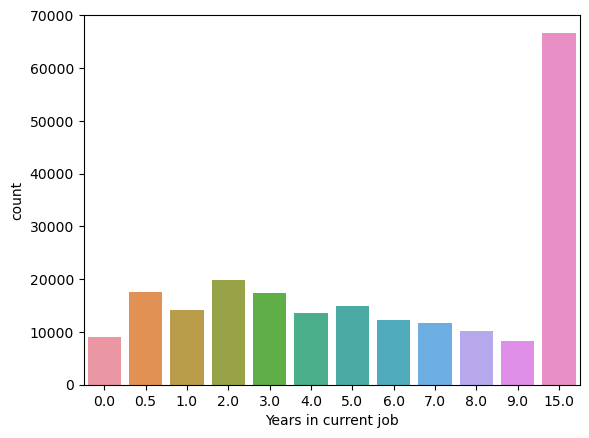

In [71]:
sns.countplot(x=df["Years in current job"])

### Creating Columns

##### Has Job?

In [72]:
df["Job"]=np.where(df["Years in current job"]=="N/A",0,1)

##### Has income?

In [73]:
df["Income"]=np.where(df["Annual Income"]>0,1,0)

##### Has Debt?

In [74]:
df["Debt"]=np.where(df["Monthly Debt"]>0,1,0)

##### Was Delinquent?

In [75]:
df["Delinquent"]=np.where(df["Months since last delinquent"]==600,0,1)

##### Has Credit Problems?

In [76]:
df["Credit Problem"]=np.where(df["Number of Credit Problems"]>0,1,0)

##### Has Credit Balance?

In [77]:
df["Credit Balance"]=np.where(df["Current Credit Balance"]>0,1,0)

##### Bankrupt?

In [78]:
df["Bankrupt"]=np.where(df["Bankruptcies"]>0,1,0)

##### Tax Liens?

In [79]:
df["hasTaxLiens"]=np.where(df["Tax Liens"]>0,1,0)

In [80]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Job,Income,Debt,Delinquent,Credit Problem,Credit Balance,Bankrupt,hasTaxLiens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,1,11520,Short Term,741.0,15.0,Home Mortgage,33694.0,Debt Consolidation,584.03,12.3,41.0,10,0,6760,16056.0,0.0,0.0,1,1,1,1,0,1,0,0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,1,3441,Short Term,734.0,4.0,Home Mortgage,42269.0,Other,1106.04,26.3,600.0,17,0,6262,19149.0,0.0,0.0,1,1,1,0,0,1,0,0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,1,21029,Short Term,747.0,15.0,Home Mortgage,90126.0,Debt Consolidation,1321.85,28.8,600.0,5,0,20967,28335.0,0.0,0.0,1,1,1,0,0,1,0,0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,1,18743,Short Term,747.0,15.0,Own Home,38072.0,Debt Consolidation,751.92,26.2,600.0,9,0,22529,43915.0,0.0,0.0,1,1,1,0,0,1,0,0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,1,11731,Short Term,746.0,4.0,Rent,50025.0,Debt Consolidation,355.18,11.5,600.0,12,0,17391,37081.0,0.0,0.0,1,1,1,0,0,1,0,0


## Modelling

In [81]:
# Dropping Unique Identifiers and Loan Status
x=df.drop(["Loan Status","Loan ID","Customer ID"],axis=1)
y=df["Loan Status"]

In [82]:
x.head()

,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Job,Income,Debt,Delinquent,Credit Problem,Credit Balance,Bankrupt,hasTaxLiens
0,11520,Short Term,741.0,15.0,Home Mortgage,33694.0,Debt Consolidation,584.03,12.3,41.0,10,0,6760,16056.0,0.0,0.0,1,1,1,1,0,1,0,0
1,3441,Short Term,734.0,4.0,Home Mortgage,42269.0,Other,1106.04,26.3,600.0,17,0,6262,19149.0,0.0,0.0,1,1,1,0,0,1,0,0
2,21029,Short Term,747.0,15.0,Home Mortgage,90126.0,Debt Consolidation,1321.85,28.8,600.0,5,0,20967,28335.0,0.0,0.0,1,1,1,0,0,1,0,0
3,18743,Short Term,747.0,15.0,Own Home,38072.0,Debt Consolidation,751.92,26.2,600.0,9,0,22529,43915.0,0.0,0.0,1,1,1,0,0,1,0,0
4,11731,Short Term,746.0,4.0,Rent,50025.0,Debt Consolidation,355.18,11.5,600.0,12,0,17391,37081.0,0.0,0.0,1,1,1,0,0,1,0,0


In [83]:
x=pd.get_dummies(x,drop_first=True)

In [84]:
x.head()

,Current Loan Amount,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Job,Income,Debt,Delinquent,Credit Problem,Credit Balance,Bankrupt,hasTaxLiens,Term_Short Term,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip
0,11520,741.0,15.0,33694.0,584.03,12.3,41.0,10,0,6760,16056.0,0.0,0.0,1,1,1,1,0,1,0,0,True,True,False,False,False,False,True,False,False,False,False,False
1,3441,734.0,4.0,42269.0,1106.04,26.3,600.0,17,0,6262,19149.0,0.0,0.0,1,1,1,0,0,1,0,0,True,True,False,False,False,False,False,False,False,False,True,False
2,21029,747.0,15.0,90126.0,1321.85,28.8,600.0,5,0,20967,28335.0,0.0,0.0,1,1,1,0,0,1,0,0,True,True,False,False,False,False,True,False,False,False,False,False
3,18743,747.0,15.0,38072.0,751.92,26.2,600.0,9,0,22529,43915.0,0.0,0.0,1,1,1,0,0,1,0,0,True,False,True,False,False,False,True,False,False,False,False,False
4,11731,746.0,4.0,50025.0,355.18,11.5,600.0,12,0,17391,37081.0,0.0,0.0,1,1,1,0,0,1,0,0,True,False,False,True,False,False,True,False,False,False,False,False


In [85]:
from sklearn.model_selection import train_test_split

In [86]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)

### Naive Bayes Model

In [87]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB

In [88]:
g=GaussianNB()
b=BernoulliNB()

In [89]:
g.fit(x_train,y_train)
b.fit(x_train,y_train)

BernoulliNB()

In [90]:
predg=g.predict(x_test)
predb=b.predict(x_test)

#### Model Evaluation

In [91]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [92]:
accuracy_score(predb,y_test)

0.8162030598052851

In [93]:
accuracy_score(predg,y_test)

0.7816179879462216

In [94]:
confusion_matrix(predg,y_test)

array([[ 2222,  3712],
       [ 5709, 31497]], dtype=int64)

In [95]:
confusion_matrix(predb,y_test)

array([[    4,     2],
       [ 7927, 35207]], dtype=int64)

In [96]:
print(classification_report(predb,y_test))

              precision    recall  f1-score   support

           0       0.00      0.67      0.00         6
           1       1.00      0.82      0.90     43134

    accuracy                           0.82     43140
   macro avg       0.50      0.74      0.45     43140
weighted avg       1.00      0.82      0.90     43140



In [97]:
print(classification_report(predg,y_test))

              precision    recall  f1-score   support

           0       0.28      0.37      0.32      5934
           1       0.89      0.85      0.87     37206

    accuracy                           0.78     43140
   macro avg       0.59      0.61      0.60     43140
weighted avg       0.81      0.78      0.79     43140



### Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression

In [99]:
l=LogisticRegression()

In [100]:
l.fit(x_train,y_train)

LogisticRegression()

In [101]:
predl=l.predict(x_test)

In [102]:
confusion_matrix(predl,y_test)

array([[    0,     2],
       [ 7931, 35207]], dtype=int64)

In [103]:
accuracy_score(predl,y_test)

0.8161103384330088

### Tree Model

In [104]:
from sklearn.tree import DecisionTreeClassifier

In [105]:
d=DecisionTreeClassifier()

In [106]:
d.fit(x_train,y_train)

DecisionTreeClassifier()

In [107]:
predd=d.predict(x_test)

In [108]:
confusion_matrix(predd,y_test)

array([[ 2832,  5645],
       [ 5099, 29564]], dtype=int64)

In [109]:
accuracy_score(predd,y_test)

0.7509503940658322

### Forest Model

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
r=RandomForestClassifier()

In [112]:
r.fit(x_train,y_train)

RandomForestClassifier()

In [113]:
predr=r.predict(x_test)

In [114]:
accuracy_score(y_test,predr)

0.8207464070468243

### Ensemble Model

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

In [116]:
gr=GradientBoostingClassifier()

In [117]:
gr.fit(x_train,y_train)

GradientBoostingClassifier()

In [118]:
predgr=gr.predict(x_test)

In [119]:
confusion_matrix(predgr,y_test)

array([[ 1164,   836],
       [ 6767, 34373]], dtype=int64)

In [120]:
accuracy_score(y_test,predgr)

0.8237598516458043

### XG Boosting

In [121]:
# pip install xgboost

In [122]:
from xgboost import XGBClassifier

In [123]:
xb=XGBClassifier()

In [124]:
x_train.head()

,Current Loan Amount,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Job,Income,Debt,Delinquent,Credit Problem,Credit Balance,Bankrupt,hasTaxLiens,Term_Short Term,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip
177517,9904,710.0,15.0,37785.0,32.74,16.4,52.0,2,0,246,297.0,0.0,0.0,1,1,1,1,0,1,0,0,False,False,False,True,False,False,True,False,False,False,False,False
8023,23582,746.0,15.0,107889.0,1159.81,18.6,600.0,11,0,25416,39713.0,0.0,0.0,1,1,1,0,0,1,0,0,True,True,False,False,False,False,True,False,False,False,False,False
151252,23506,714.0,3.0,166498.0,908.80,30.0,32.0,7,0,21072,38105.0,0.0,0.0,1,1,1,1,0,1,0,0,False,False,False,True,False,False,True,False,False,False,False,False
141896,19772,678.0,1.0,89963.0,1162.02,38.5,19.0,21,0,20895,59872.0,0.0,0.0,1,1,1,1,0,1,0,0,False,False,False,True,False,False,True,False,False,False,False,False
71321,6999,701.0,15.0,87866.0,893.30,17.7,23.0,7,0,3052,3064.0,0.0,0.0,1,1,1,1,0,1,0,0,True,True,False,False,False,False,True,False,False,False,False,False


In [125]:
xb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [126]:
predxb=xb.predict(x_test)

In [127]:
accuracy_score(y_test,predxb)

0.823041261010663

In [128]:
def classification_funct(x,y):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier #pip install xgboost
    
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    from sklearn.metrics import confusion_matrix,classification_report
       
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
       
    g=GaussianNB()
    b=BernoulliNB()
    KN=KNeighborsClassifier() 
    D=DecisionTreeClassifier()
    R=RandomForestClassifier()
    Log=LogisticRegression()
    gr=GradientBoostingClassifier()
    XGB=XGBClassifier()
    
    algos=[g,b,KN,D,R,Log,gr,XGB]
    algo_names=['GaussianNB','BernoulliNB','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','LogisticRegression','GBClassifier','XGBClassifier']
    
    accuracy_scored=[]

    
    for item in algos:
        item.fit(x_train,y_train)
        print("\n {} confusion_matrix".format(item))
        print(confusion_matrix(y_test,item.predict(x_test)))
        print("\n {} classification_report".format(item))
        print(classification_report(y_test,item.predict(x_test)))

        accuracy_scored.append(accuracy_score(y_test,item.predict(x_test)))
      
      
    result=pd.DataFrame(columns=['f1_score','accuracy_score'],index=algo_names)
  
    result['accuracy_score']=accuracy_scored
    classification_funct.result=result.sort_values('accuracy_score',ascending=False)

In [131]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
classification_funct(x,y)


 GaussianNB() confusion_matrix
[[ 2222  5709]
 [ 3712 31497]]

 GaussianNB() classification_report
              precision    recall  f1-score   support

           0       0.37      0.28      0.32      7931
           1       0.85      0.89      0.87     35209

    accuracy                           0.78     43140
   macro avg       0.61      0.59      0.60     43140
weighted avg       0.76      0.78      0.77     43140


 BernoulliNB() confusion_matrix
[[    4  7927]
 [    2 35207]]

 BernoulliNB() classification_report
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      7931
           1       0.82      1.00      0.90     35209

    accuracy                           0.82     43140
   macro avg       0.74      0.50      0.45     43140
weighted avg       0.79      0.82      0.73     43140


 KNeighborsClassifier() confusion_matrix


AttributeError: 'Flags' object has no attribute 'c_contiguous'

### Accuracy Score = 82.375
### Best Model : Gradient Boosting Classifier